# Kaggle Space Titanic Competition

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

 - **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
 - **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
 - **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
 - **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
 - **Destination** - The planet the passenger will be debarking to.
 - **Age** - The age of the passenger.
 - **VIP** - Whether the passenger has paid for special VIP service during the voyage.
 - **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
 - **Name** - The first and last names of the passenger.
 - **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# Imports

## Package imports
Import all packages needed to run your code here. 

You can install packages by running a cell with the following code: `!pip install <LIBRARY_NAME>`

In [23]:
import os
from pathlib import Path
base_dir_joblib_temp_folder = "./~joblib"
Path(base_dir_joblib_temp_folder).mkdir(exist_ok=True, parents=True)
os.environ["JOBLIB_TEMP_FOLDER"] = str(base_dir_joblib_temp_folder)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import numpy as np

import xgboost as XGB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold


plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
pd.set_option('display.max_rows', 100); pd.set_option('display.max_columns', 200); 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Data Import

In [25]:
cache_train = pd.read_csv("data/train.csv")
cache_test = pd.read_csv("data/test.csv")

cache_train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


## Feature Engineering

In [26]:
both_df = [cache_train.copy(), cache_test.copy()]

### Expenditure, Luxuries and ExpensesTransported

We will calculate the total expenditure and using RoolService, Spa etc and calculate the passengers with no expenditure

In [27]:
expence_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
luxury_feats = ['RoomService', 'Spa', 'VRDeck']
essential_feats = ['FoodCourt', 'ShoppingMall']

for df in both_df:
    df['ExpensesTotal'] = df[expence_feats].sum(axis=1)
    df['ExpensesLuxury'] = df[luxury_feats].sum(axis=1)
    df['ExpencesEssential'] = df[essential_feats].sum(axis=1)
    df['No_spend'] = (df['ExpensesTotal']==0).astype(int)

### Decoding combined variables - Passenger group

Extract passenger group and group size from PassengerId.

In [28]:
for df in both_df:
    df['Group'] = df['PassengerId'].str.extract('(\A[0-9]+)', expand=False)
    group_counts = df['Group'].value_counts()
    df['Group_size'] = df['Group'].map(lambda x: group_counts[x])

In [29]:
for df in both_df:
    df['Lone'] = (df['Group_size']==1).astype(int)

### Decoding combined variables - Cabin deck, number and side

In [30]:
# Cabin deck/num/side:
for df in both_df:
    df['Cabin_deck'] = df.Cabin.str.extract('(\A[A-Za-z]+)', expand=False)
    cabin_num_mean = 9999 # fill with recognizable variable
    df['Cabin_num'] = df.Cabin.str.extract('([0-9]+)', expand=False).fillna(cabin_num_mean).astype(int)
    df.loc[df['Cabin_num']==9999, 'Cabin_num']=np.nan # replace back with NaN
    df['Cabin_side'] = df.Cabin.str.extract('([A-Za-z]+\Z)', expand=False)

both_df[0].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.00,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.00,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.00,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.00,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.00,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.00,0.0,46.0,24133.0
ExpensesTotal,8693.0,1440.866329,2803.045694,0.0,0.00,716.0,1441.0,35987.0
ExpensesLuxury,8693.0,822.860002,1830.912512,0.0,0.00,59.0,848.0,28600.0
ExpencesEssential,8693.0,618.006327,1696.461254,0.0,0.00,1.0,600.0,29813.0
No_spend,8693.0,0.420223,0.493623,0.0,0.00,0.0,1.0,1.0


In [31]:
both_df[0].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,ExpensesTotal,ExpensesLuxury,ExpencesEssential,No_spend,Group,Group_size,Lone,Cabin_deck,Cabin_num,Cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0.0,0.0,1,0001,1,1,B,0.0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,702.0,34.0,0,0002,1,1,F,0.0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,6807.0,3576.0,0,0003,2,0,A,0.0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,3522.0,1654.0,0,0003,2,0,A,0.0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,870.0,221.0,0,0004,1,1,F,1.0,S


## Missing values

Combine train and test for convenience.

In [32]:
df = pd.concat([both_df[0].copy(), both_df[1].copy()], axis=0).reset_index(drop=True)
print(df.isna().sum())
df.shape

PassengerId             0
HomePlanet            288
CryoSleep             310
Cabin                 299
Destination           274
Age                   270
VIP                   296
RoomService           263
FoodCourt             289
ShoppingMall          306
Spa                   284
VRDeck                268
Name                  294
Transported          4277
ExpensesTotal           0
ExpensesLuxury          0
ExpencesEssential       0
No_spend                0
Group                   0
Group_size              0
Lone                    0
Cabin_deck            299
Cabin_num             299
Cabin_side            299
dtype: int64


(12970, 24)

In [33]:
df['Cabin_num'].fillna(df['Cabin_num'].mean(), inplace=True)
df['Cabin_num_Group300'] = df['Cabin_num'].floordiv(300).astype(int)

In [34]:
df['VIP'].fillna(False, inplace=True)

In [35]:
df['Age'].fillna(df['Age'].mean(), inplace=True)

In [36]:
df['CryoSleep'].fillna(False, inplace = True) 

In [37]:
for col in expence_feats:
    df[col].fillna(0, inplace = True)

In [38]:
df['ExpensesTotal'] = df[expence_feats].sum(axis=1)
df['No_spend'] = (df['ExpensesTotal']==0).astype(int)
df['ExpensesLuxury'] = df[luxury_feats].sum(axis=1)
df['ExpencesEssential'] = df[essential_feats].sum(axis=1)

### Age_g - three categories: under 4, 5-17 and  18+

In [39]:
df.loc[(df.Age <= 4), 'Age_g'] = 0
df.loc[((4 < df.Age) & (df.Age < 18)), 'Age_g'] = 1
df.loc[(df.Age >= 18), 'Age_g'] = 2

df['Age'] = df['Age'].astype(int)
df['Age_g'] = df['Age_g'].astype(int)

Drop unnecessary columns

In [40]:
df.drop(['Cabin', 'Name', 'Group_size', 'Cabin_num', 'Group'],axis=1,inplace =True)

In [41]:
print(df.shape)
df.isna().sum()

(12970, 21)


PassengerId              0
HomePlanet             288
CryoSleep                0
Destination            274
Age                      0
VIP                      0
RoomService              0
FoodCourt                0
ShoppingMall             0
Spa                      0
VRDeck                   0
Transported           4277
ExpensesTotal            0
ExpensesLuxury           0
ExpencesEssential        0
No_spend                 0
Lone                     0
Cabin_deck             299
Cabin_side             299
Cabin_num_Group300       0
Age_g                    0
dtype: int64

# Preprocessing

### Encoding categorical values

In [42]:
# Cabin_deck
df = pd.get_dummies(df, columns=['Cabin_deck'])
# Home Planet
df = pd.get_dummies(df, columns=['HomePlanet'])
# Destination
df = pd.get_dummies(df, columns=['Destination'])
# Cabin_side
df = pd.get_dummies(df, columns=['Cabin_side'])

# CryoSleep and VIP bool to numerical
df['CryoSleep'] = df['CryoSleep'].astype(int) * 10
df['VIP'] = df['VIP'].astype(int)

### The logarithm transform of expenses

Used to decrease skew in distributions, especially with large outliers

In [43]:
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','ExpensesTotal', 'ExpensesLuxury', 'ExpencesEssential']:
    df[col]=np.log10(1+df[col])

**Split the data back into train and test sets**

In [44]:
train_e_df= df[df['PassengerId'].isin(cache_train['PassengerId'].values)].copy()
test_e_df = df[df['PassengerId'].isin(cache_test['PassengerId'].values)].copy()
combined_df = [train_e_df, test_e_df]

combined_df[0].shape, combined_df[1].shape

((8693, 33), (4277, 33))

**Convert Label to 0/1 and set index to Passenger_id**

In [45]:
# Convert also label and drop from test set
combined_df[0]['Transported'] = combined_df[0]['Transported'].astype(int)
combined_df[1].drop(columns=['Transported'], inplace=True)
# set index
for df in combined_df:
    df.set_index('PassengerId', inplace=True)

### Cross- correlation table

<AxesSubplot:>

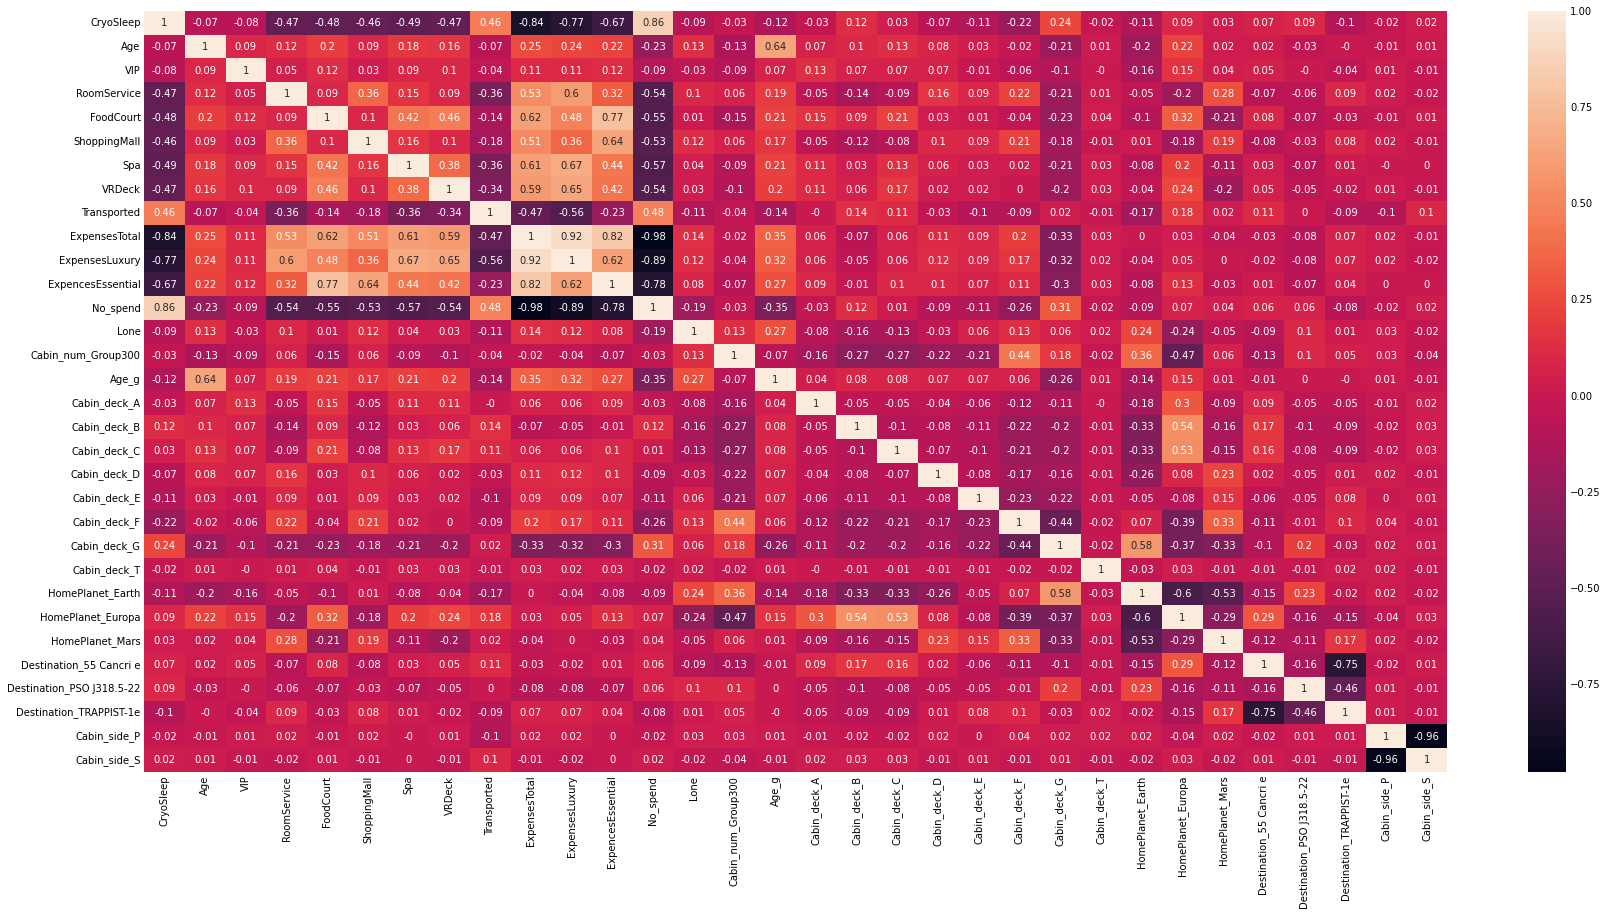

In [46]:
#correlation between all features
fig, ax = plt.subplots(figsize=(26,14))
matrix = combined_df[0].corr().round(2)
sns.heatmap(matrix, annot=True)

## Selecting predictive features

In [47]:
list(combined_df[0])

['CryoSleep',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Transported',
 'ExpensesTotal',
 'ExpensesLuxury',
 'ExpencesEssential',
 'No_spend',
 'Lone',
 'Cabin_num_Group300',
 'Age_g',
 'Cabin_deck_A',
 'Cabin_deck_B',
 'Cabin_deck_C',
 'Cabin_deck_D',
 'Cabin_deck_E',
 'Cabin_deck_F',
 'Cabin_deck_G',
 'Cabin_deck_T',
 'HomePlanet_Earth',
 'HomePlanet_Europa',
 'HomePlanet_Mars',
 'Destination_55 Cancri e',
 'Destination_PSO J318.5-22',
 'Destination_TRAPPIST-1e',
 'Cabin_side_P',
 'Cabin_side_S']

In [48]:
FEATURES= ['CryoSleep',
           'Cabin_num_Group300',
           'VIP', 'Lone',
           'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
           'ExpensesTotal', 'ExpensesLuxury', 'ExpencesEssential',
           'Cabin_deck_A', 'Cabin_deck_B', 'Cabin_deck_C', 'Cabin_deck_D', 'Cabin_deck_E', 'Cabin_deck_F', 'Cabin_deck_G', 
           'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 
           'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 
           'Cabin_side_P', 'Cabin_side_S',
           'Age', 'Age_g']

TARGET = ['Transported']

train_df = combined_df[0].copy()
test_df = combined_df[1].copy()

# Modeling

## CatBoost

In [49]:
model = CatBoostClassifier(random_state=1013)

score = cross_val_score(model, train_df[FEATURES].values, train_df['Transported'].values,
                        n_jobs=-1, cv= 5)
print("Mean score: {}".format(score.mean()))
print("Lowest score: {}".format(min(score)))
print("Best score: {}".format(max(score)))

Mean score: 0.8011076032083304
Lowest score: 0.7625071880391029
Best score: 0.8354430379746836


In [50]:
model = CatBoostClassifier(random_state=1013, learning_rate=0.020131)

model.fit(train_df[FEATURES], train_df[TARGET]['Transported'].values, verbose=False)

predictions = model.predict(test_df[FEATURES])

submission = pd.read_csv('data/sample_submission.csv')
submission['Transported'] = predictions.astype(bool)
submission.to_csv('submission.csv', index=False)

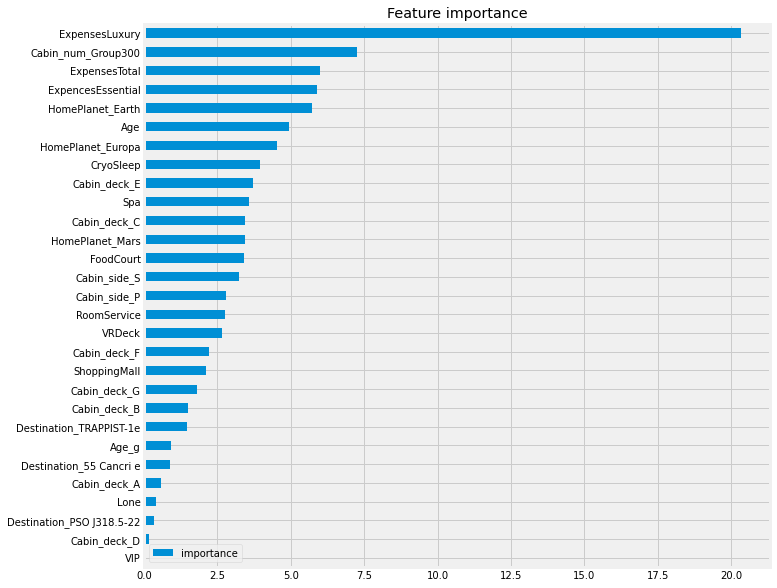

In [51]:
fi = pd.DataFrame(data = model.feature_importances_, index = model.feature_names_, columns = ['importance'])
fi = fi.sort_values('importance').plot(kind='barh', title="Feature importance", figsize=[10,10])